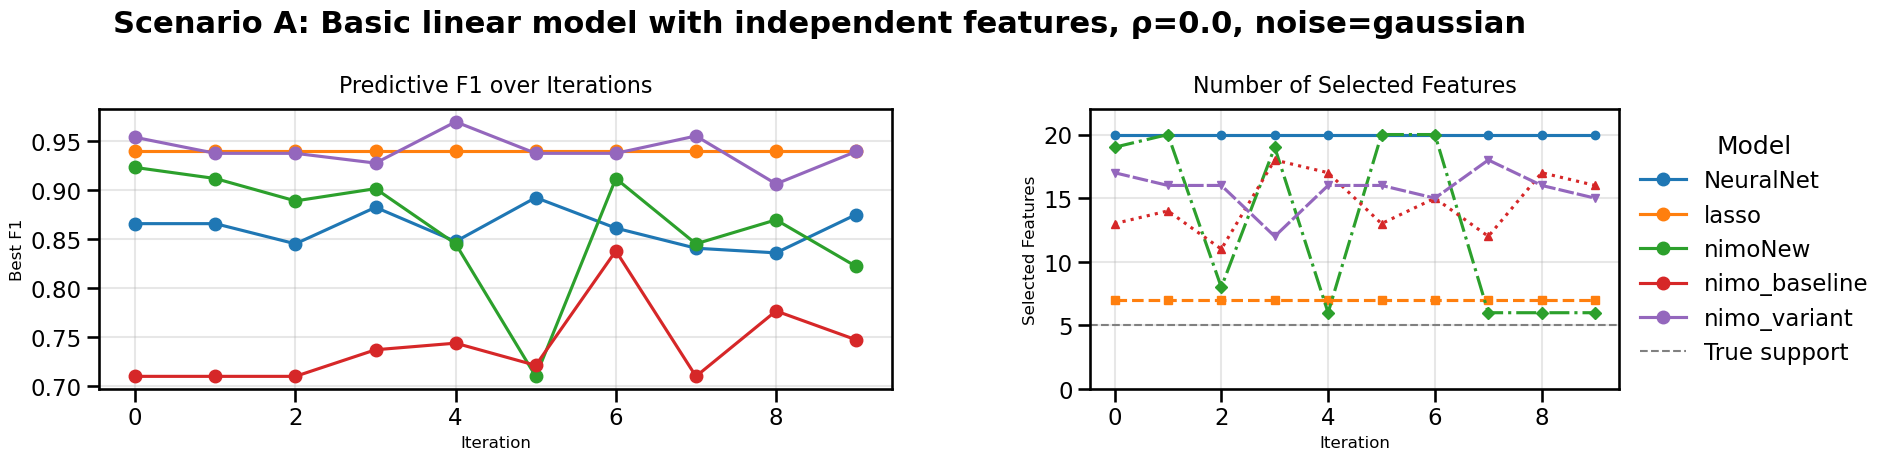

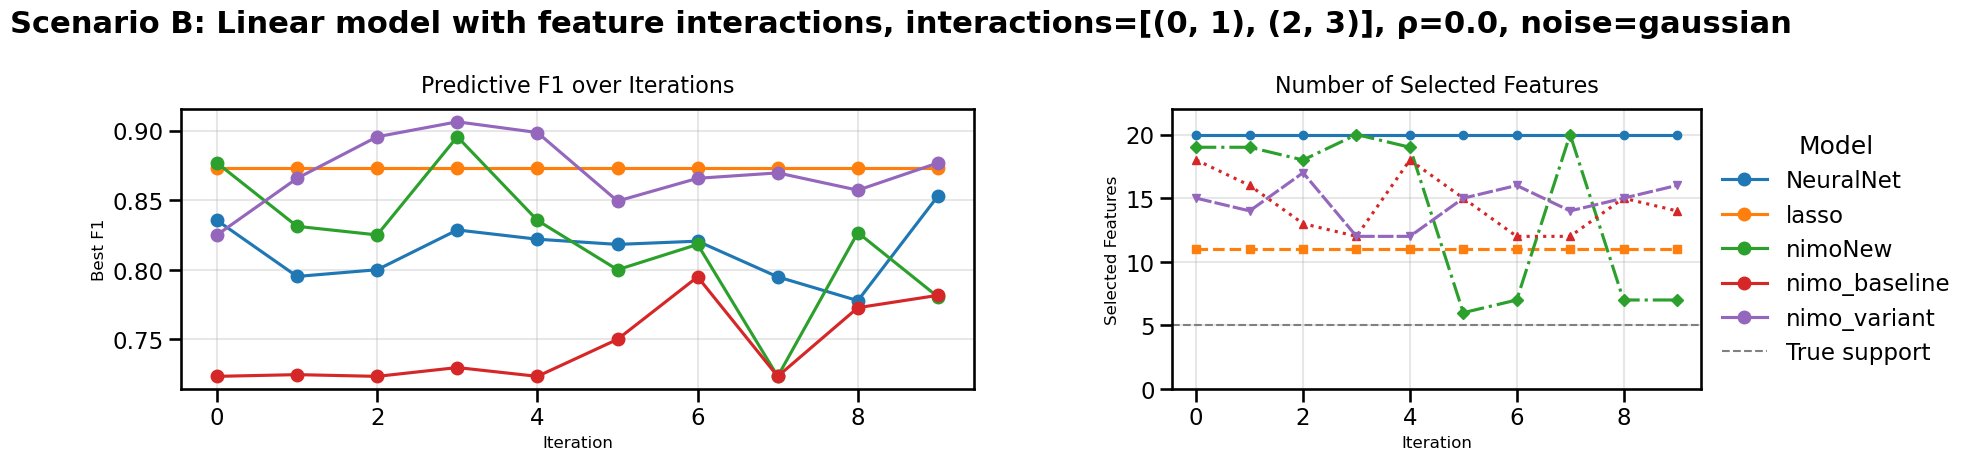

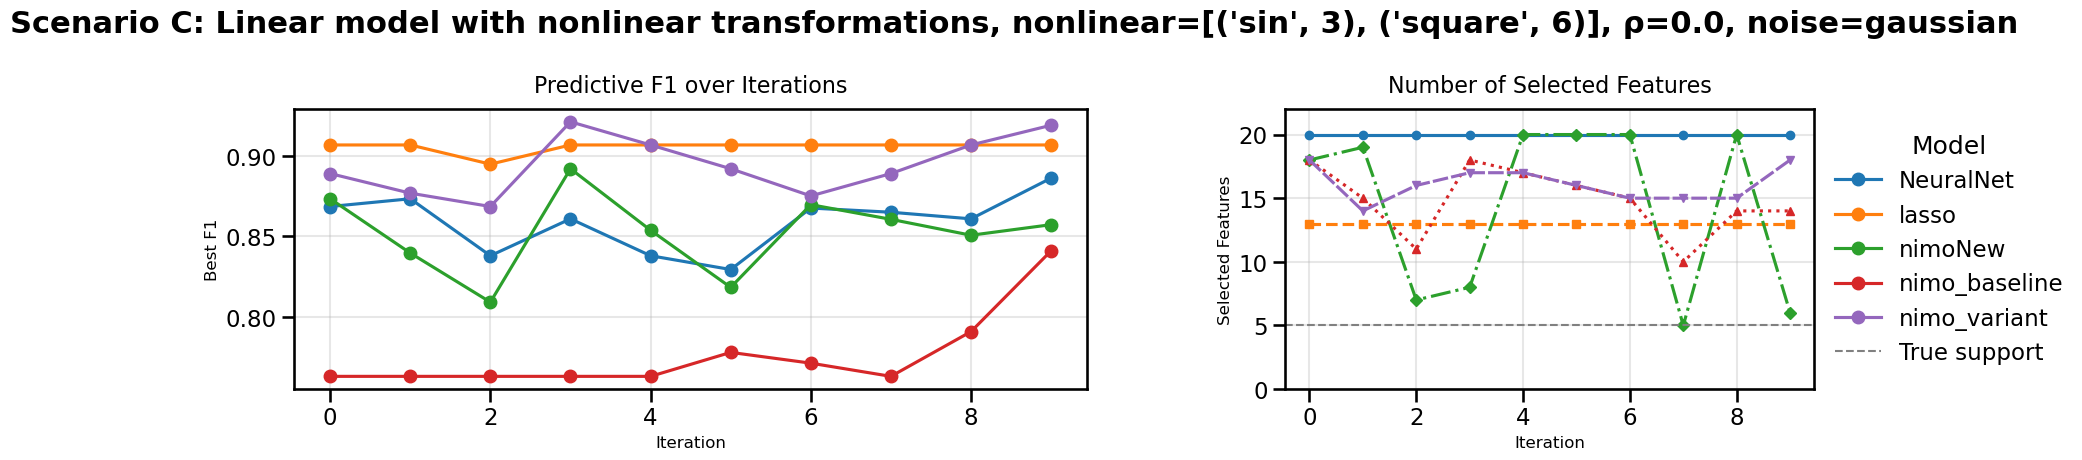

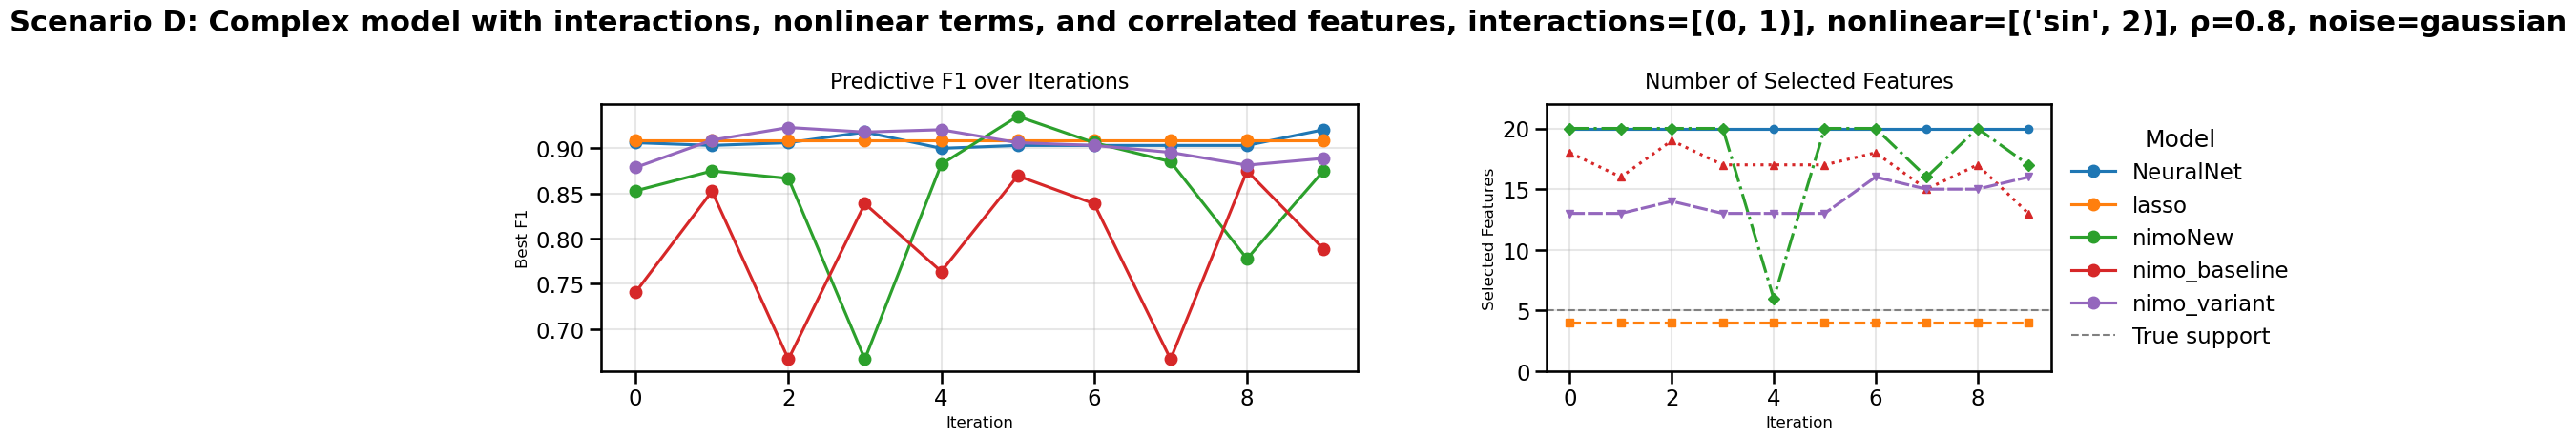

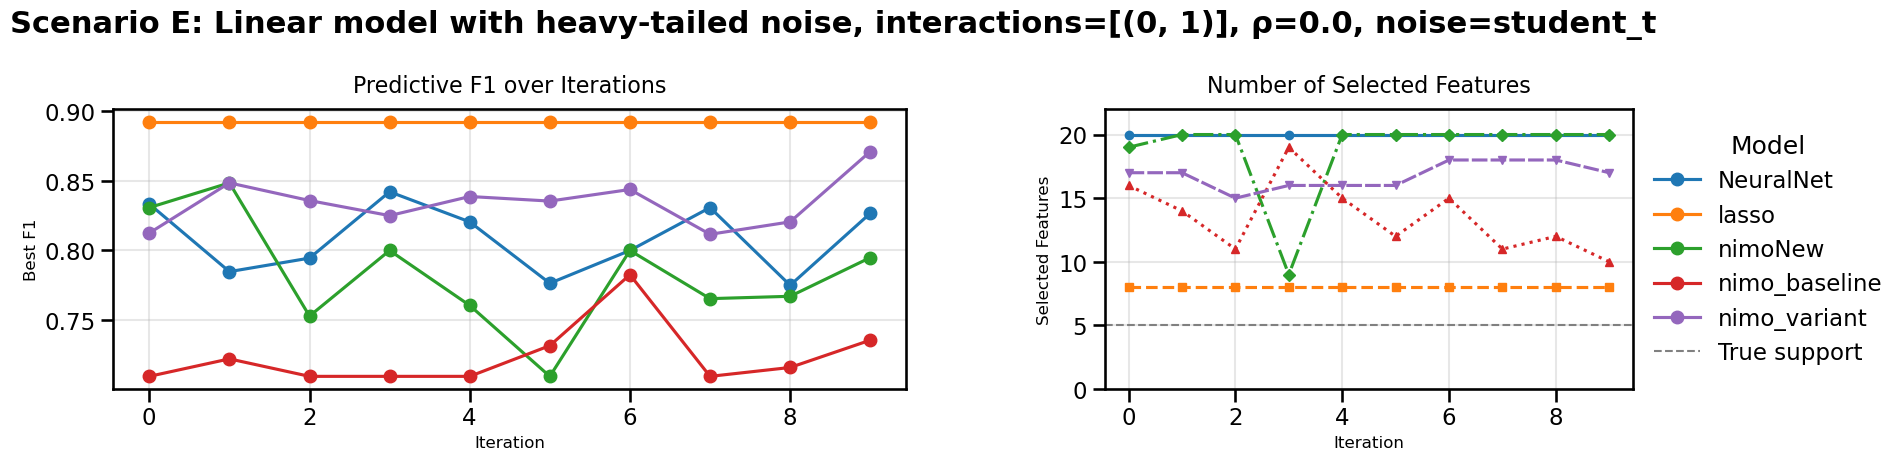

/var/folders/nm/wffg_5x13dv69w58yk8x6vhc0000gn/T/ipykernel_10499/52209192.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


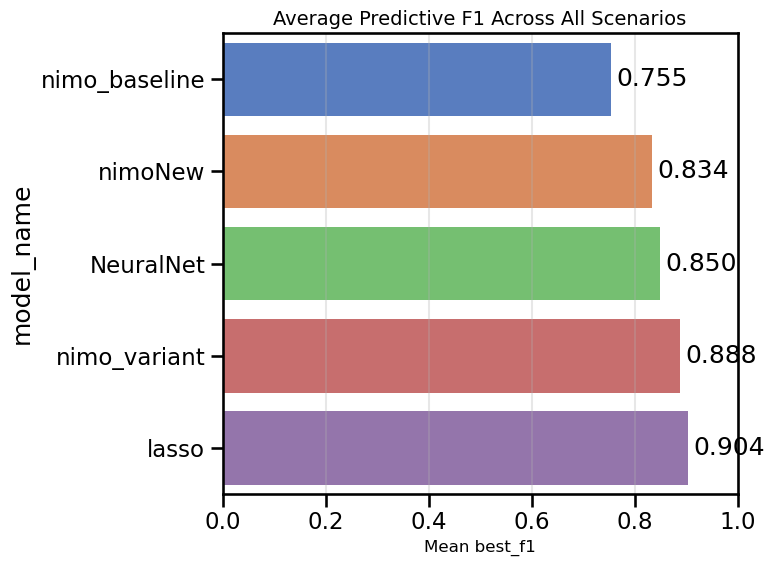

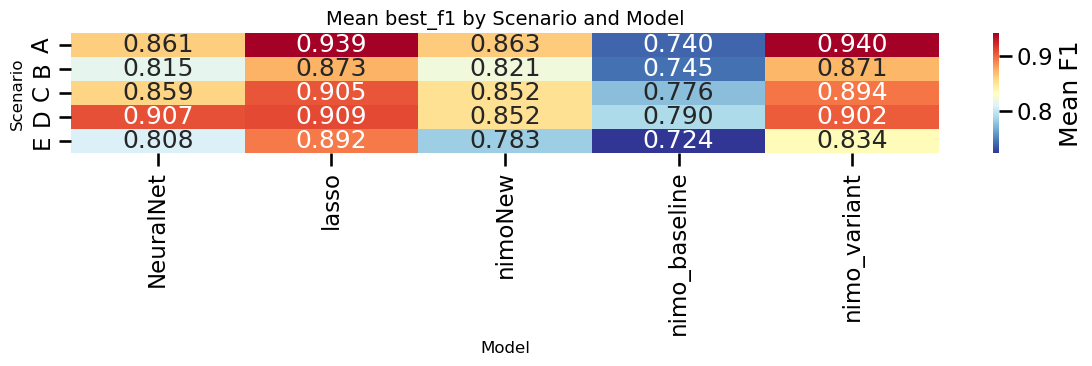

In [55]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

# -------------------------------
# 1) Daten einlesen & vorbereiten
# -------------------------------
df = pd.read_csv('../results/synthetic/all_model_results_synthetic.csv')
if 'error' in df.columns:
    df = df[df['error'].isna()].reset_index(drop=True)

df['selected_features'] = (
    df['selected_features']
      .fillna('[]')
      .apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else [])
)
df['n_selected'] = df['selected_features'].apply(len)

for col in ['best_f1', 'n_selected', 'f1_recovery', 'n_true_features']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

desc_map  = df.groupby('scenario')['scenario_description'].first().to_dict()
scenarios = sorted(df['scenario'].unique())
methods   = sorted(df['model_name'].unique())

# Einheitliche Farben
palette = sns.color_palette("tab10", n_colors=len(methods))
palette = dict(zip(methods, palette))

linestyles = ['-', '--', '-.', ':', (0, (5,1))]
markers    = ['o', 's', 'D', '^', 'v']

# Y-Limit für Selected Features
ylim_upper = df['n_selected'].max()
if 'n_true_features' in df.columns:
    ylim_upper = max(ylim_upper, df['n_true_features'].max())
ylim_upper += 2

# -------------------------------
# 2) Pro Scenario: 2‑Spalten‑Layout
# -------------------------------
for scen in scenarios:
    grp  = df[df['scenario']==scen]
    desc = desc_map[scen]

    fig, axes = plt.subplots(
        nrows=1, ncols=2,
        figsize=(16, 4),
        constrained_layout=False,
        gridspec_kw={'width_ratios':[3,2]}
    )

    # Haupttitel
    fig.suptitle(
        f"Scenario {desc}",
        fontsize=22,
        fontweight='bold',
        y=1.10
    )

    # ----- Linke Spalte: Predictive F1 -----
    ax1 = axes[0]
    for method in methods:
        sub = grp[grp['model_name']==method]
        if sub.empty: continue
        ax1.plot(
            sub['iteration'], sub['best_f1'],
            color=palette[method], marker='o', linestyle='-',
            label=method
        )
    ax1.set_title("Predictive F1 over Iterations", fontsize=16, pad=12)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Best F1", fontsize=12)
    ax1.grid(alpha=0.3)

    # ----- Rechte Spalte: Selected Features -----
    ax2 = axes[1]
    for i, method in enumerate(methods):
        sub = grp[grp['model_name']==method]
        if sub.empty: continue
        ax2.plot(
            sub['iteration'], sub['n_selected'],
            color=palette[method],
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=6,
            label=method
        )
    if 'n_true_features' in grp.columns:
        ax2.axhline(
            grp['n_true_features'].iloc[0],
            ls='--', color='gray', linewidth=1.5,
            label='True support'
        )
    ax2.set_title("Number of Selected Features", fontsize=16, pad=12)
    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("Selected Features", fontsize=12)
    ax2.set_ylim(0, ylim_upper)
    ax2.grid(alpha=0.3)

    # ----- Gemeinsame Legende außen -----
    # sammle Handles und Labels von beiden Achsen
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles, labels = [], []
    for h, l in zip(handles1 + handles2, labels1 + labels2):
        if l not in labels:
            handles.append(h)
            labels.append(l)

    # Platziere die Legende weiter rechts
    fig.legend(
        handles=handles,
        labels=labels,
        title="Model",
        bbox_to_anchor=(1.0, 0.5),
        loc='center left',
        frameon=False
    )

    # Passe die Subplots so an, dass rechts mehr Platz bleibt
    fig.subplots_adjust(left=0.05, right=1, top=0.85, bottom=0.15, wspace=0.3)

    plt.show()



    # --- 3) Average F1 Barplot ---
avg_f1 = df.groupby('model_name')['best_f1'].mean().sort_values()
plt.figure(figsize=(8, 6))
sns.barplot(
    x=avg_f1.values,
    y=avg_f1.index,
    palette="muted"
)
for i, (val, lab) in enumerate(zip(avg_f1.values, avg_f1.index)):
    plt.text(val + 0.01, i, f"{val:.3f}", va='center')
plt.title("Average Predictive F1 Across All Scenarios", fontsize=14)
plt.xlabel("Mean best_f1", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4) Predictive F1 Heatmap (mean best_f1) ---


# Pivot-Tabelle wie gehabt
heat_df = df.pivot_table(
    index='scenario',
    columns='model_name',
    values='best_f1',
    aggfunc='mean'
)

# Dynamische Min/Max-Werte
vmin = heat_df.values.min()
vmax = heat_df.values.max()

plt.figure(figsize=(12, 4))
sns.heatmap(
    heat_df,
    annot=True,
    fmt=".3f",
    cmap="RdYlBu_r",     # Kontraststärkere Diverging-Palette
    vmin=vmin,           # Am Daten-Minimum ausrichten
    vmax=vmax,           # Am Daten-Maximum ausrichten
    cbar_kws={'label': 'Mean F1'}
)
plt.title("Mean best_f1 by Scenario and Model", fontsize=14)
plt.ylabel("Scenario", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()
